# **Lending Club Default Analysis**

The analysis is divided into four main parts:
1. Data understanding 
2. Data cleaning (cleaning missing values, removing redundant columns etc.)
3. Data Analysis 
4. Recommendations

In [1]:
from google.colab import files
uploaded = files.upload()

Saving loan.csv to loan.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

loan = pd.read_csv("loan.csv", sep=",")
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## **Data Understanding**

In [3]:
# let's look at the first few rows of the df
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0,Jan-96,0,38.0,NaN,15,0,27783,53.90%,38,f,524.06,524.06,3513.330000,3513.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [4]:
# Looking at all the column names
loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)

Some of the important columns in the dataset are loan_amount, term, interest rate, grade, sub grade, annual income, purpose of the loan etc.

The **target variable**, which we want to compare across the independent variables, is loan status. The strategy is to figure out compare the average default rates across various independent variables and identify the  ones that affect default rate the most.

## **Data Cleaning**

Some columns have a large number of missing values, let's first fix the missing values and then check for other types of data quality problems.

In [5]:
# summarising number of missing values in each column
loan.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

In [6]:
# percentage of missing values in each column
round(loan.isnull().sum()/len(loan.index), 2)*100

id                              0.0
member_id                       0.0
loan_amnt                       0.0
funded_amnt                     0.0
funded_amnt_inv                 0.0
                              ...  
tax_liens                       0.0
tot_hi_cred_lim               100.0
total_bal_ex_mort             100.0
total_bc_limit                100.0
total_il_high_credit_limit    100.0
Length: 111, dtype: float64

You can see that many columns have 100% missing values, some have 65%, 33% etc. First, let's get rid of the columns having 100% missing values.

In [7]:
# removing the columns having more than 90% missing values
missing_columns = loan.columns[100*(loan.isnull().sum()/len(loan.index)) > 90]
print(missing_columns)

Index(['mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
       'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
       'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
 

In [8]:
loan = loan.drop(missing_columns, axis=1)
print(loan.shape)

(39717, 55)


In [9]:
# summarise number of missing values again
100*(loan.isnull().sum()/len(loan.index))

id                             0.000000
member_id                      0.000000
loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      6.191303
emp_length                     2.706650
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
loan_status                    0.000000
pymnt_plan                     0.000000
url                            0.000000
desc                          32.580507
purpose                        0.000000
title                          0.027696
zip_code                       0.000000
addr_state                     0.000000
dti                            0.000000


In [10]:
# There are now 2 columns having approx 32 and 64% missing values - 
# description and months since last delinquent

# let's have a look at a few entries in the columns
loan.loc[:, ['desc', 'mths_since_last_delinq']].head()

,desc,mths_since_last_delinq
0,Borrower added on 12/22/11 > I need to upgra...,NaN
1,Borrower added on 12/22/11 > I plan to use t...,NaN
2,NaN,NaN
3,Borrower added on 12/21/11 > to pay for prop...,35.0
4,Borrower added on 12/21/11 > I plan on combi...,38.0


The column description contains the comments the applicant had written while applying for the loan. Although one can use some text analysis techniques to derive new features from this column (such as sentiment, number of positive/negative words etc.), we will not use this column in this analysis. 

Secondly, months since last delinquent represents the number months passed since the person last fell into the 90 DPD group. There is an important reason we shouldn't use this column in analysis - since at the time of loan application, we will not have this data (it gets generated months after the loan has been approved), it cannot be used as a predictor of default at the time of loan approval. 

Thus let's drop the two columns.

In [11]:
# dropping the two columns
loan = loan.drop(['desc', 'mths_since_last_delinq'], axis=1)

In [12]:
# summarise number of missing values again
100*(loan.isnull().sum()/len(loan.index))

id                            0.000000
member_id                     0.000000
loan_amnt                     0.000000
funded_amnt                   0.000000
funded_amnt_inv               0.000000
term                          0.000000
int_rate                      0.000000
installment                   0.000000
grade                         0.000000
sub_grade                     0.000000
emp_title                     6.191303
emp_length                    2.706650
home_ownership                0.000000
annual_inc                    0.000000
verification_status           0.000000
issue_d                       0.000000
loan_status                   0.000000
pymnt_plan                    0.000000
url                           0.000000
purpose                       0.000000
title                         0.027696
zip_code                      0.000000
addr_state                    0.000000
dti                           0.000000
delinq_2yrs                   0.000000
earliest_cr_line         

There are some more columns with missing values, but let's ignore them for now (since we are ntot doing any modeling, we don't need to impute all missing values anyway). 

But let's check whether some rows have a large number of missing values.

In [13]:
# missing values in rows
loan.isnull().sum(axis=1)

0        1
1        0
2        1
3        0
4        0
        ..
39712    4
39713    4
39714    5
39715    5
39716    4
Length: 39717, dtype: int64

In [14]:
# checking whether some rows have more than 5 missing values
len(loan[loan.isnull().sum(axis=1) > 5].index)

0

The data looks clean by and large. Let's also check whether all columns are in the correct format.

In [15]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [16]:
# The column int_rate is character type, let's convert it to float
loan['int_rate'] = loan['int_rate'].apply(lambda x: pd.to_numeric(x.split("%")[0]))

In [17]:
# checking the data types
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  float64
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [18]:
# also, lets extract the numeric part from the variable employment length

# first, let's drop the missing values from the column (otherwise the regex code below throws error)
loan = loan[~loan['emp_length'].isnull()]

# using regular expression to extract numeric values from the string
import re
loan['emp_length'] = loan['emp_length'].apply(lambda x: re.findall('\d+', str(x))[0])

# convert to numeric
loan['emp_length'] = loan['emp_length'].apply(lambda x: pd.to_numeric(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
# looking at type of the columns again
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38642 entries, 0 to 39716
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          38642 non-null  int64  
 1   member_id                   38642 non-null  int64  
 2   loan_amnt                   38642 non-null  int64  
 3   funded_amnt                 38642 non-null  int64  
 4   funded_amnt_inv             38642 non-null  float64
 5   term                        38642 non-null  object 
 6   int_rate                    38642 non-null  float64
 7   installment                 38642 non-null  float64
 8   grade                       38642 non-null  object 
 9   sub_grade                   38642 non-null  object 
 10  emp_title                   37202 non-null  object 
 11  emp_length                  38642 non-null  int64  
 12  home_ownership              38642 non-null  object 
 13  annual_inc                  386

## **Data Analysis**

Let's now move to data analysis. To start with, let's understand the objective of the analysis clearly and identify the variables that we want to consider for analysis. 

The objective is to identify predictors of default so that at the time of loan application, we can use those variables for approval/rejection of the loan. Now, there are broadly three types of variables - 1. those which are related to the applicant (demographic variables such as age, occupation, employment details etc.), 2. loan characteristics (amount of loan, interest rate, purpose of loan etc.) and 3. Customer behaviour variables (those which are generated after the loan is approved such as delinquent 2 years, revolving balance, next payment date etc.).

Now, the customer behaviour variables are not available at the time of loan application, and thus they cannot be used as predictors for credit approval. 

Thus, going forward, we will use only the other two types of variables.

In [20]:
behaviour_var =  [
  "delinq_2yrs",
  "earliest_cr_line",
  "inq_last_6mths",
  "open_acc",
  "pub_rec",
  "revol_bal",
  "revol_util",
  "total_acc",
  "out_prncp",
  "out_prncp_inv",
  "total_pymnt",
  "total_pymnt_inv",
  "total_rec_prncp",
  "total_rec_int",
  "total_rec_late_fee",
  "recoveries",
  "collection_recovery_fee",
  "last_pymnt_d",
  "last_pymnt_amnt",
  "last_credit_pull_d",
  "application_type"]
behaviour_var

['delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'application_type']

In [21]:
# let's now remove the behaviour variables from analysis
df = loan.drop(behaviour_var, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38642 entries, 0 to 39716
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          38642 non-null  int64  
 1   member_id                   38642 non-null  int64  
 2   loan_amnt                   38642 non-null  int64  
 3   funded_amnt                 38642 non-null  int64  
 4   funded_amnt_inv             38642 non-null  float64
 5   term                        38642 non-null  object 
 6   int_rate                    38642 non-null  float64
 7   installment                 38642 non-null  float64
 8   grade                       38642 non-null  object 
 9   sub_grade                   38642 non-null  object 
 10  emp_title                   37202 non-null  object 
 11  emp_length                  38642 non-null  int64  
 12  home_ownership              38642 non-null  object 
 13  annual_inc                  386

Typically, variables such as acc_now_delinquent, chargeoff within 12 months etc. (which are related to the applicant's past loans) are available from the credit bureau.

In [22]:
# also, we will not be able to use the variables zip code, address, state etc.
# the variable 'title' is derived from the variable 'purpose'
# thus let get rid of all these variables as well

df = df.drop(['title', 'url', 'zip_code', 'addr_state'], axis=1)

Next, let's have a look at the target variable - loan_status. We need to relabel the values to a binary form - 0 or 1, 1 indicating that the person has defaulted and 0 otherwise.

In [23]:
df['loan_status'] = df['loan_status'].astype('category')
df['loan_status'].value_counts()

Fully Paid     32145
Charged Off     5399
Current         1098
Name: loan_status, dtype: int64

You can see that fully paid comprises most of the loans. The ones marked 'current' are neither fully paid not defaulted, so let's get rid of the current loans. Also, let's tag the other two values as 0 or 1. 

In [24]:
# filtering only fully paid or charged-off
df = df[df['loan_status'] != 'Current']
df['loan_status'] = df['loan_status'].apply(lambda x: 0 if x=='Fully Paid' else 1)

# converting loan_status to integer type
df['loan_status'] = df['loan_status'].apply(lambda x: pd.to_numeric(x))

# summarising the values
df['loan_status'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    32145
1     5399
Name: loan_status, dtype: int64

Next, let's start with univariate analysis and then move to bivariate analysis.

## **Univariate Analysis**

First, let's look at the overall default rate.

In [25]:
# default rate
round(np.mean(df['loan_status']), 2)

0.14

The overall default rate is about 14%. 

Let's first visualise the average default rates across categorical variables.

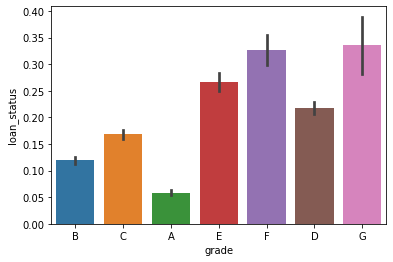

In [26]:
# plotting default rates across grade of the loan
sns.barplot(x='grade', y='loan_status', data=df)
plt.show()

In [27]:
# lets define a function to plot loan_status across categorical variables
def plot_cat(cat_var):
    sns.barplot(x=cat_var, y='loan_status', data=df)
    plt.show()

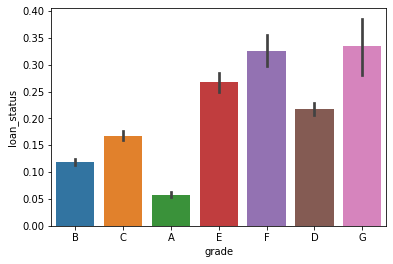

In [28]:
# compare default rates across grade of loan
plot_cat('grade')

Clearly, as the grade of loan goes from A to G, the default rate increases. This is expected because the grade is decided by Lending Club based on the riskiness of the loan. 

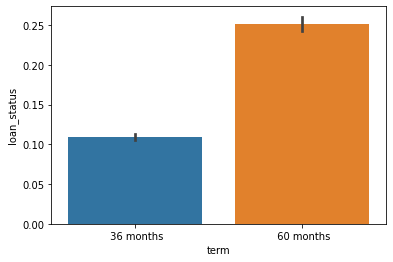

In [29]:
# term: 60 months loans default more than 36 months loans
plot_cat('term')

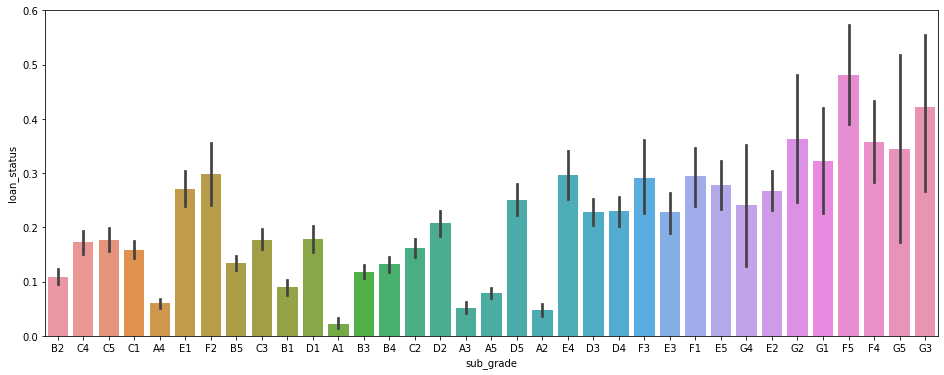

In [30]:
# sub-grade: as expected - A1 is better than A2 better than A3 and so on 
plt.figure(figsize=(16, 6))
plot_cat('sub_grade')

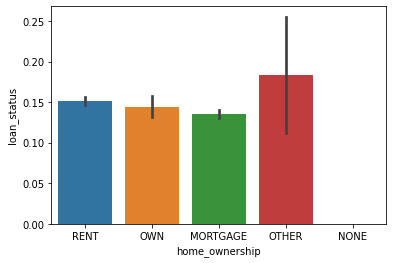

In [31]:
# home ownership: not a great discriminator
plot_cat('home_ownership')

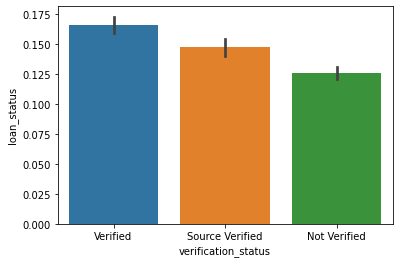

In [32]:
# verification_status: surprisingly, verified loans default more than not verifiedb
plot_cat('verification_status')

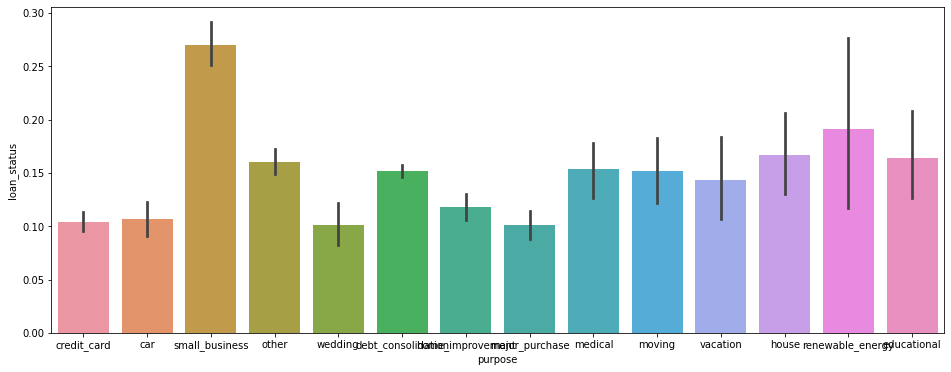

In [33]:
# purpose: small business loans defualt the most, then renewable energy and education
plt.figure(figsize=(16, 6))
plot_cat('purpose')

In [34]:
# let's also observe the distribution of loans across years
# first lets convert the year column into datetime and then extract year and month from it
df['issue_d'].head()

0    Dec-11
1    Dec-11
2    Dec-11
3    Dec-11
5    Dec-11
Name: issue_d, dtype: object

In [35]:
from datetime import datetime
df['issue_d'] = df['issue_d'].apply(lambda x: datetime.strptime(x, '%b-%y'))

In [36]:
# extracting month and year from issue_date
df['month'] = df['issue_d'].apply(lambda x: x.month)
df['year'] = df['issue_d'].apply(lambda x: x.year)

In [37]:
# let's first observe the number of loans granted across years
df.groupby('year').year.count()

year
2007      251
2008     1562
2009     4716
2010    11214
2011    19801
Name: year, dtype: int64

You can see that the number of loans has increased steadily across years. 

In [38]:
# number of loans across months
df.groupby('month').month.count()

month
1     2331
2     2278
3     2632
4     2756
5     2838
6     3094
7     3253
8     3321
9     3394
10    3637
11    3890
12    4120
Name: month, dtype: int64

Most loans are granted in December, and in general in the latter half of the year.

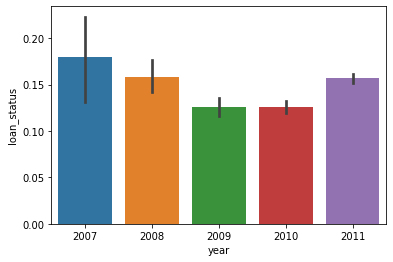

In [39]:
# lets compare the default rates across years
# the default rate had suddenly increased in 2011, inspite of reducing from 2008 till 2010
plot_cat('year')

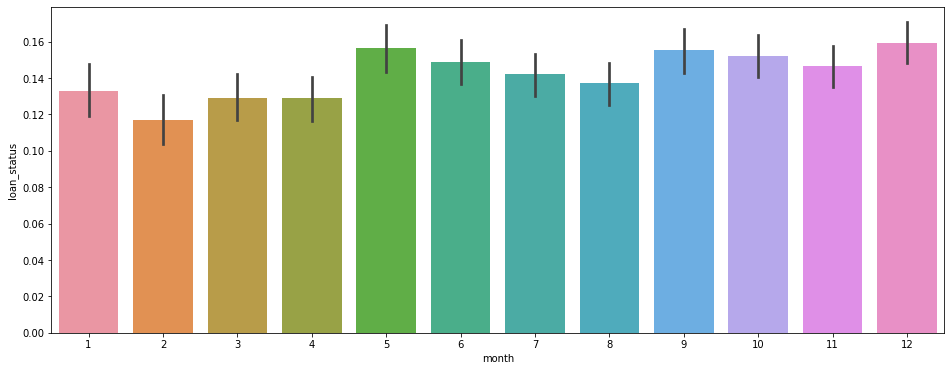

In [40]:
# comparing default rates across months: not much variation across months
plt.figure(figsize=(16, 6))
plot_cat('month')

Let's now analyse how the default rate varies across continuous variables.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


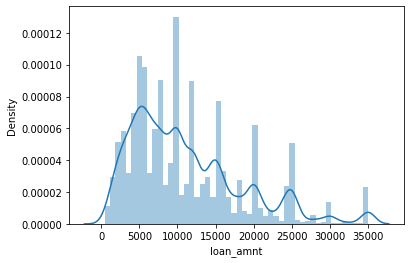

In [41]:
# loan amount: the median loan amount is around 10,000
sns.distplot(df['loan_amnt'])
plt.show()

The easiest way to analyse how default rates vary across continous variables is to bin the variables into discrete categories.

Let's bin the loan amount variable into small, medium, high, very high.

In [42]:
# binning loan amount
def loan_amount(n):
    if n < 5000:
        return 'low'
    elif n >=5000 and n < 15000:
        return 'medium'
    elif n >= 15000 and n < 25000:
        return 'high'
    else:
        return 'very high'
        
df['loan_amnt'] = df['loan_amnt'].apply(lambda x: loan_amount(x))

In [43]:
df['loan_amnt'].value_counts()

medium       20157
high          7572
low           7095
very high     2720
Name: loan_amnt, dtype: int64

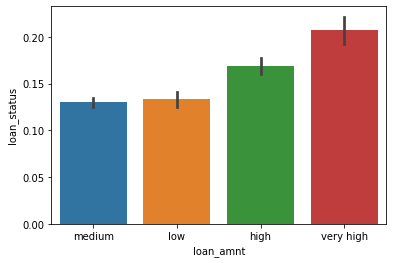

In [44]:
# let's compare the default rates across loan amount type
# higher the loan amount, higher the default rate
plot_cat('loan_amnt')

In [45]:
# let's also convert funded amount invested to bins
df['funded_amnt_inv'] = df['funded_amnt_inv'].apply(lambda x: loan_amount(x))

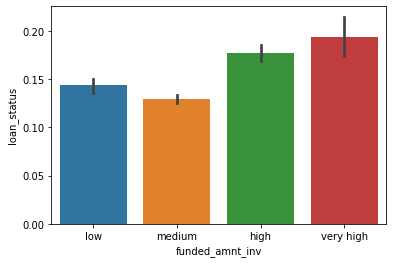

In [46]:
# funded amount invested
plot_cat('funded_amnt_inv')

In [47]:
# lets also convert interest rate to low, medium, high
# binning loan amount
def int_rate(n):
    if n <= 10:
        return 'low'
    elif n > 10 and n <=15:
        return 'medium'
    else:
        return 'high'
    
    
df['int_rate'] = df['int_rate'].apply(lambda x: int_rate(x))

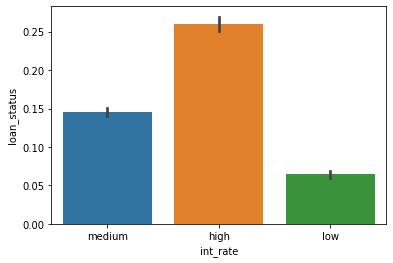

In [48]:
# comparing default rates across rates of interest
# high interest rates default more, as expected
plot_cat('int_rate')

In [49]:
# debt to income ratio
def dti(n):
    if n <= 10:
        return 'low'
    elif n > 10 and n <=20:
        return 'medium'
    else:
        return 'high'
    

df['dti'] = df['dti'].apply(lambda x: dti(x))

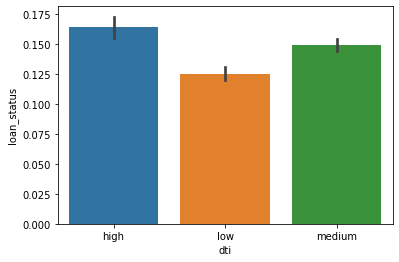

In [50]:
# comparing default rates across debt to income ratio
# high dti translates into higher default rates, as expected
plot_cat('dti')

In [51]:
# funded amount
def funded_amount(n):
    if n <= 5000:
        return 'low'
    elif n > 5000 and n <=15000:
        return 'medium'
    else:
        return 'high'
    
df['funded_amnt'] = df['funded_amnt'].apply(lambda x: funded_amount(x))

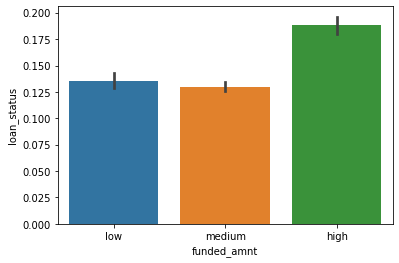

In [52]:
plot_cat('funded_amnt')

In [53]:
# installment
def installment(n):
    if n <= 200:
        return 'low'
    elif n > 200 and n <=400:
        return 'medium'
    elif n > 400 and n <=600:
        return 'high'
    else:
        return 'very high'
    
df['installment'] = df['installment'].apply(lambda x: installment(x))

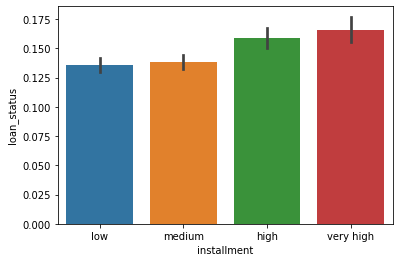

In [54]:
# comparing default rates across installment
# the higher the installment amount, the higher the default rate
plot_cat('installment')

In [55]:
# annual income
def annual_income(n):
    if n <= 50000:
        return 'low'
    elif n > 50000 and n <=100000:
        return 'medium'
    elif n > 100000 and n <=150000:
        return 'high'
    else:
        return 'very high'

df['annual_inc'] = df['annual_inc'].apply(lambda x: annual_income(x))

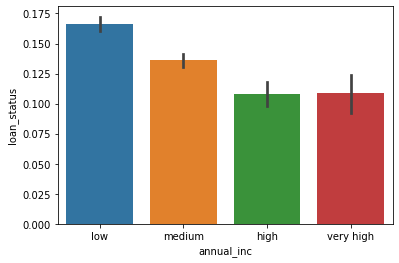

In [56]:
# annual income and default rate
# lower the annual income, higher the default rate
plot_cat('annual_inc')

In [57]:
# employment length
# first, let's drop the missing value observations in emp length
df = df[~df['emp_length'].isnull()]

# binning the variable
def emp_length(n):
    if n <= 1:
        return 'fresher'
    elif n > 1 and n <=3:
        return 'junior'
    elif n > 3 and n <=7:
        return 'senior'
    else:
        return 'expert'

df['emp_length'] = df['emp_length'].apply(lambda x: emp_length(x))

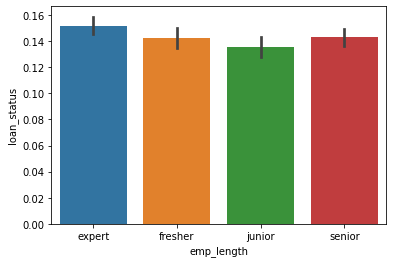

In [58]:
# emp_length and default rate
# not much of a predictor of default
plot_cat('emp_length')

## **Segmented Univariate Analysis**

We have now compared the default rates across various variables, and some of the important predictors are purpose of the loan, interest rate, annual income, grade etc.

In the credit industry, one of the most important factors affecting default is the purpose of the loan - home loans perform differently than credit cards, credit cards are very different from debt condolidation loans etc. 

This comes from business understanding, though let's again have a look at the default rates across the purpose of the loan.

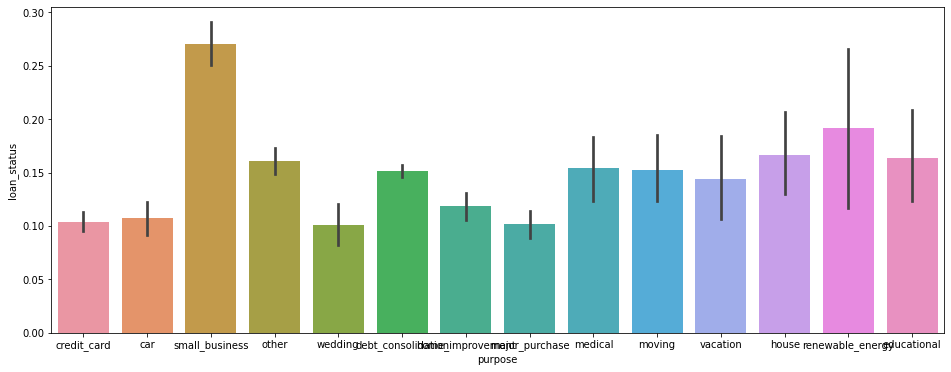

In [59]:
# purpose: small business loans defualt the most, then renewable energy and education
plt.figure(figsize=(16, 6))
plot_cat('purpose')

In the upcoming analyses, we will segment the loan applications across the purpose of the loan, since that is a variable affecting many other variables - the type of applicant, interest rate, income, and finally the default rate. 

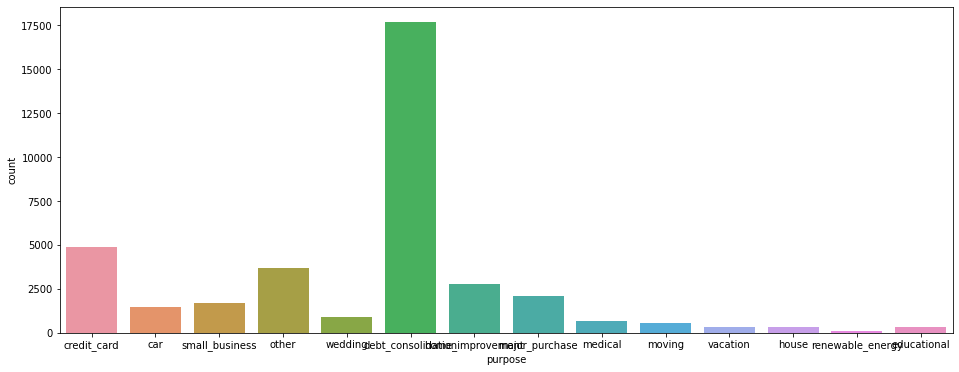

In [60]:
# lets first look at the number of loans for each type (purpose) of the loan
# most loans are debt consolidation (to repay otehr debts), then credit card, major purchase etc.
plt.figure(figsize=(16, 6))
sns.countplot(x='purpose', data=df)
plt.show()

Let's analyse the top 4 types of loans based on purpose: consolidation, credit card, home improvement and major purchase.

In [61]:
# filtering the df for the 4 types of loans mentioned above
main_purposes = ["credit_card","debt_consolidation","home_improvement","major_purchase"]
df = df[df['purpose'].isin(main_purposes)]
df['purpose'].value_counts()

debt_consolidation    17675
credit_card            4899
home_improvement       2785
major_purchase         2080
Name: purpose, dtype: int64

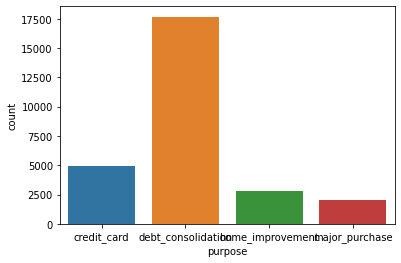

In [62]:
# plotting number of loans by purpose 
sns.countplot(x=df['purpose'])
plt.show()

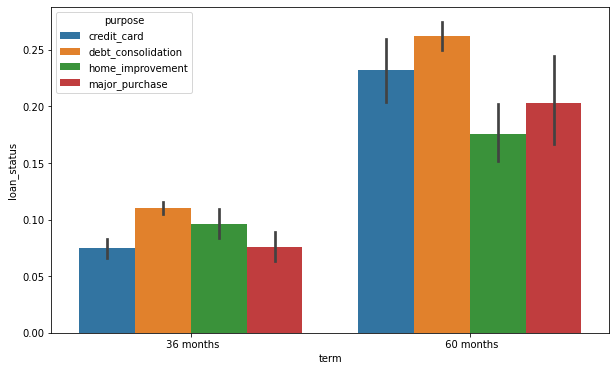

In [63]:
# let's now compare the default rates across two types of categorical variables
# purpose of loan (constant) and another categorical variable (which changes)

plt.figure(figsize=[10, 6])
sns.barplot(x='term', y="loan_status", hue='purpose', data=df)
plt.show()

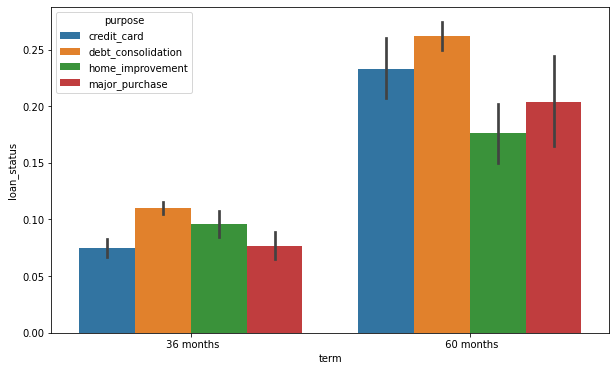

In [64]:
# lets write a function which takes a categorical variable and plots the default rate
# segmented by purpose 

def plot_segmented(cat_var):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cat_var, y='loan_status', hue='purpose', data=df)
    plt.show()

    
plot_segmented('term')

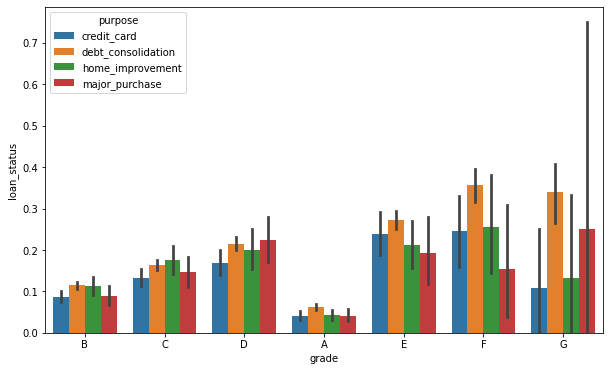

In [65]:
# grade of loan
plot_segmented('grade')

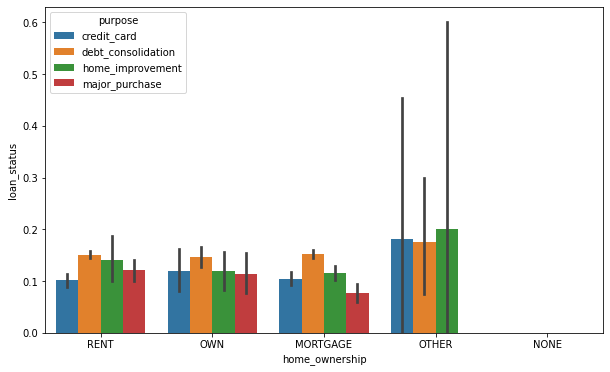

In [66]:
# home ownership
plot_segmented('home_ownership')

In general, debt consolidation loans have the highest default rates. Lets compare across other categories as well.

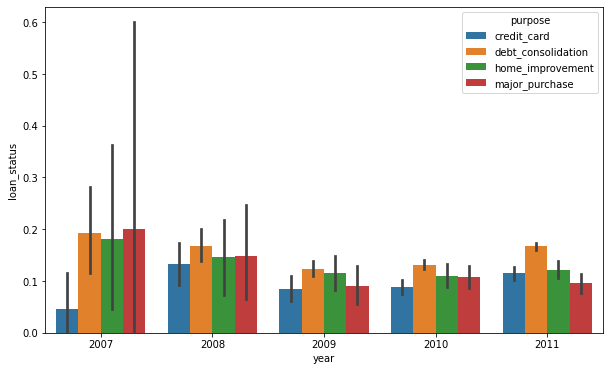

In [67]:
# year
plot_segmented('year')

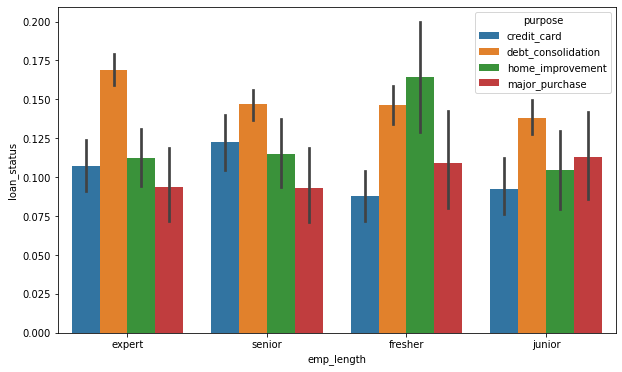

In [68]:
# emp_length
plot_segmented('emp_length')

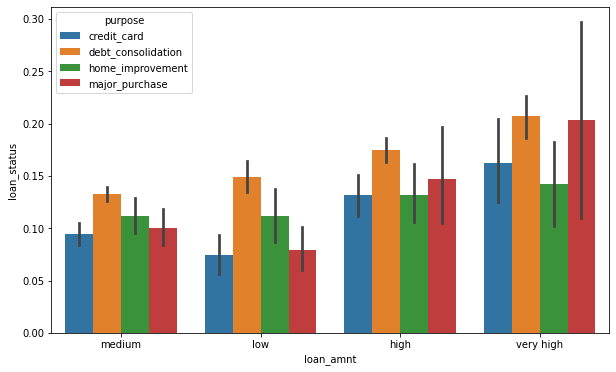

In [69]:
# loan_amnt: same trend across loan purposes
plot_segmented('loan_amnt')

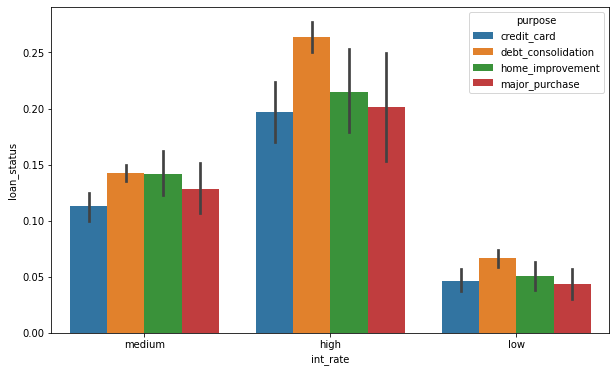

In [70]:
# interest rate
plot_segmented('int_rate')

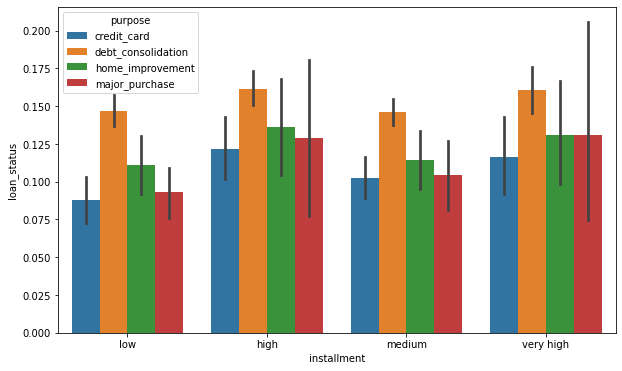

In [71]:
# installment
plot_segmented('installment')

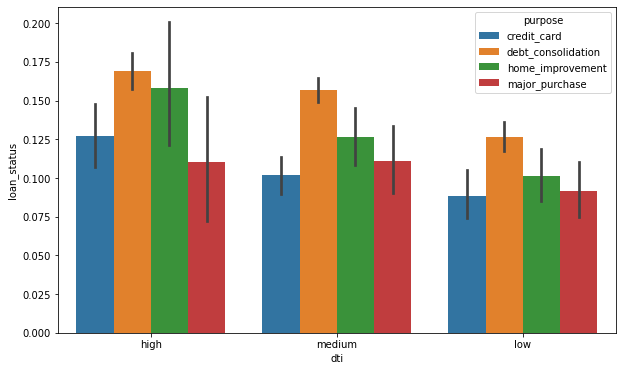

In [72]:
# debt to income ratio
plot_segmented('dti')

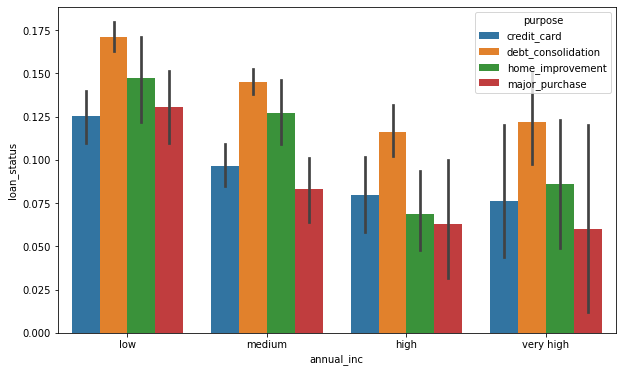

In [73]:
# annual income
plot_segmented('annual_inc')

A good way to quantify th effect of a categorical variable on default rate is to see 'how much does the default rate vary across the categories'. 

Let's see an example using annual_inc as the categorical variable.

In [74]:
# variation of default rate across annual_inc
df.groupby('annual_inc').loan_status.mean().sort_values(ascending=False)

annual_inc
low          0.157966
medium       0.130075
very high    0.101570
high         0.097749
Name: loan_status, dtype: float64

In [75]:
# one can write a function which takes in a categorical variable and computed the average 
# default rate across the categories
# It can also compute the 'difference between the highest and the lowest default rate' across the 
# categories, which is a decent metric indicating the effect of the varaible on default rate

def diff_rate(cat_var):
    default_rates = df.groupby(cat_var).loan_status.mean().sort_values(ascending=False)
    return (round(default_rates, 2), round(default_rates[0] - default_rates[-1], 2))

default_rates, diff = diff_rate('annual_inc')
print(default_rates) 
print(diff)

annual_inc
low          0.16
medium       0.13
very high    0.10
high         0.10
Name: loan_status, dtype: float64
0.06


Thus, there is a 6% increase in default rate as you go from high to low annual income. We can compute this difference for all the variables and roughly identify the ones that affect default rate the most.

In [76]:
# filtering all the object type variables
df_categorical = df.loc[:, df.dtypes == object]
df_categorical['loan_status'] = df['loan_status']

# Now, for each variable, we can compute the incremental diff in default rates
print([i for i in df.columns])

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'dti', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens', 'month', 'year']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
# storing the diff of default rates for each column in a dict
d = {key: diff_rate(key)[1]*100 for key in df_categorical.columns if key != 'loan_status'}
print(d)

{'loan_amnt': 7.000000000000001, 'funded_amnt': 5.0, 'funded_amnt_inv': 6.0, 'term': 15.0, 'int_rate': 19.0, 'installment': 3.0, 'grade': 27.0, 'sub_grade': 46.0, 'emp_title': 100.0, 'emp_length': 2.0, 'home_ownership': 16.0, 'annual_inc': 6.0, 'verification_status': 4.0, 'pymnt_plan': 0.0, 'purpose': 5.0, 'dti': 5.0, 'initial_list_status': 0.0}
